## Libraries



In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# foldername = '/home/mrsergazinov/python-git-workspace/gluformer/'
foldername = '/content/drive/My Drive/github/gluformer/'
assert foldername is not None, "[!] Enter the foldername."

# add path to .py code
import sys
sys.path.append(foldername)

Mounted at /content/drive


In [2]:
%%capture
!pip install pytorch-lightning==1.4.9
!pip install pytorch-forecasting
!pip install pandas --upgrade

In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Preprocessing Data

In [2]:
foldername = '/home/mrsergazinov/python-git-workspace/gluformer/'

path = foldername + 'gludata/data'
with open(path+"/test_data_pyforecast.pkl", 'rb') as f:
      test_data_raw = pickle.load(f)

In [3]:
def read_data(data):
    data_len = sum([len(data[i][1]) for i in range(len(data))])
    data_pd = pd.DataFrame(index = range(data_len),
                           columns = ["id", "segment", "timeidx", "CGM", 
                                      "dayofyear", "dayofmonth", "dayofweek", "hour", 
                                      "minute", "date"])
    start = 0
    for i in range(len(data)):
        block_len = len(data[i][1]) 
        data_pd["id"][start:(start+block_len)] = [data[i][0]] * block_len
        data_pd["segment"][start:(start+block_len)] = [str(i)] * block_len 
        data_pd["timeidx"][start:(start+block_len)] = range(block_len)
        data_pd["CGM"][start:(start+block_len)] = data[i][1].flatten() 
        data_pd["date"][start:(start+block_len)] = data[i][3]
        start += block_len
    
    # set format
    data_pd["timeidx"] = data_pd["timeidx"].astype("int")
    data_pd["CGM"] = data_pd["CGM"].astype("float")
    
    #extract time features
    data_pd["date"] = pd.to_datetime(data_pd["date"])
    data_pd["dayofyear"] = data_pd["date"].dt.dayofyear.astype("string").astype("category")
    data_pd["dayofmonth"] = data_pd["date"].dt.day.astype("string").astype("category")
    data_pd["dayofweek"] = data_pd["date"].dt.dayofweek.astype("string").astype("category")
    data_pd["hour"] = data_pd["date"].dt.hour.astype("string").astype("category")
    data_pd["minute"] = data_pd["date"].dt.minute.astype("string").astype("category")
    
    # add id and segment 
    data_pd["id"] = data_pd["id"].astype(str).astype("string").astype("category")
    data_pd["segment"] = data_pd["segment"].astype(str).astype("string").astype("category")
    
    # reset index
    data_pd = data_pd.reset_index()
    data_pd = data_pd.drop(columns=["index"])
    return data_pd

test_data_pd = read_data(test_data_raw)

In [14]:
test_data = TimeSeriesDataSet(
    test_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id", "segment"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["id"],
    time_varying_known_categoricals= ["dayofyear", 
                                      "dayofmonth", 
                                      "dayofweek", 
                                      "hour",
                                      "minute"],
    time_varying_known_reals=["timeidx"],
    time_varying_unknown_reals = ["CGM"],
    target_normalizer=None,
    add_relative_time_idx=True,
    add_encoder_length=True,
)
test_dataloader = test_data.to_dataloader(train=False, batch_size=32, num_workers=0)

In [5]:
test_data_pd

,id,segment,timeidx,CGM,dayofyear,dayofmonth,dayofweek,hour,minute,date
0,0,0,0,-2.362637,259,16,0,23,2,2013-09-16 23:02:00
1,0,0,1,-2.362637,259,16,0,23,7,2013-09-16 23:07:00
2,0,0,2,-2.362637,259,16,0,23,12,2013-09-16 23:12:00
3,0,0,3,-2.390110,259,16,0,23,17,2013-09-16 23:17:00
4,0,0,4,-2.362637,259,16,0,23,22,2013-09-16 23:22:00
...,...,...,...,...,...,...,...,...,...,...
24047,37,51,462,-2.582418,82,23,5,4,23,2013-03-23 04:23:00
24048,37,51,463,-2.582418,82,23,5,4,28,2013-03-23 04:28:00
24049,37,51,464,-2.472527,82,23,5,4,33,2013-03-23 04:33:00
24050,37,51,465,-2.417582,82,23,5,4,38,2013-03-23 04:38:00


In [6]:
test_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24052 entries, 0 to 24051
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          24052 non-null  category      
 1   segment     24052 non-null  category      
 2   timeidx     24052 non-null  int64         
 3   CGM         24052 non-null  float64       
 4   dayofyear   24052 non-null  category      
 5   dayofmonth  24052 non-null  category      
 6   dayofweek   24052 non-null  category      
 7   hour        24052 non-null  category      
 8   minute      24052 non-null  category      
 9   date        24052 non-null  datetime64[ns]
dtypes: category(7), datetime64[ns](1), float64(1), int64(1)
memory usage: 737.0 KB


## Evaluating Model

In [5]:
tft = TemporalFusionTransformer.from_dataset(
    test_data,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
tft_fitted = tft.load_from_checkpoint(foldername+'/logs-compare/saved_models/tft.ckpt')

In [6]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft_fitted.predict(test_dataloader)

In [7]:
# scale predictions
UPPER = 402
LOWER = 38
SCALE_1 = 5
SCALE_2 = 2
actuals = (actuals + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
predictions = (predictions + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER

In [8]:
actuals[1]

tensor([234.0000, 232.0000, 229.5000, 227.0000, 220.0000, 219.0000, 214.0000,
        209.0000, 207.0000, 196.0000, 195.0000, 184.0000])

In [9]:
predictions[1]

tensor([231.5124, 228.8256, 226.4629, 223.4963, 220.5917, 217.6724, 214.7961,
        212.0831, 209.0318, 206.1016, 203.2808, 200.3548], dtype=torch.float64)

In [11]:
((actuals - predictions).abs() / actuals.abs()).mean(axis=1).median()

tensor(0.0777, dtype=torch.float64)

In [25]:
raw_predictions, x = tft_fitted.predict(test_dataloader, mode="raw", return_x=True)

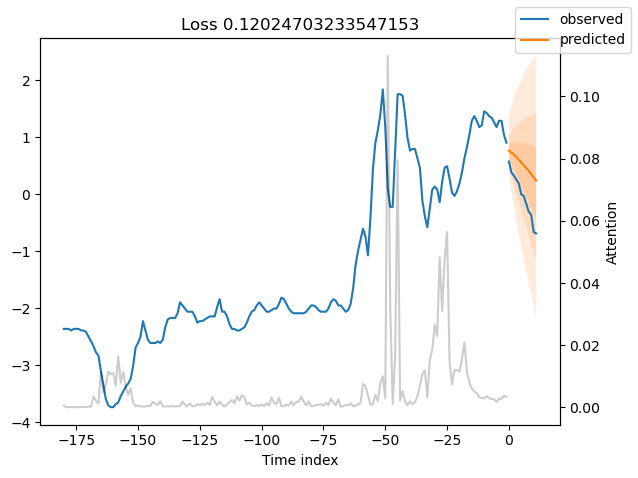

In [30]:
tft_fitted.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)

In [29]:
raw_predictions['prediction'][0, :, :]

tensor([[ 0.3771,  0.5184,  0.6524,  0.7685,  0.8915,  1.0177,  1.3682],
        [ 0.0595,  0.3347,  0.5428,  0.7309,  0.9071,  1.0973,  1.5501],
        [-0.2119,  0.1794,  0.4503,  0.6975,  0.9192,  1.1649,  1.6973],
        [-0.4606,  0.0279,  0.3553,  0.6578,  0.9240,  1.2163,  1.8158],
        [-0.7088, -0.1269,  0.2548,  0.6070,  0.9113,  1.2503,  1.9231],
        [-0.9289, -0.2754,  0.1571,  0.5573,  0.9002,  1.2779,  2.0057],
        [-1.1424, -0.4214,  0.0616,  0.5096,  0.8908,  1.3144,  2.1085],
        [-1.3454, -0.5658, -0.0324,  0.4614,  0.8817,  1.3420,  2.1873],
        [-1.5569, -0.7146, -0.1290,  0.4132,  0.8718,  1.3730,  2.2659],
        [-1.7454, -0.8542, -0.2310,  0.3533,  0.8483,  1.3802,  2.3122],
        [-1.9420, -0.9999, -0.3319,  0.3004,  0.8318,  1.4039,  2.3882],
        [-2.1623, -1.1636, -0.4446,  0.2391,  0.8067,  1.4124,  2.4305]],
       dtype=torch.float64)